In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from datetime import datetime
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from time import time

In [2]:
fred_md = pd.read_csv("data/Fred_MD_Current.csv")
fred_md.drop(0,axis=0, inplace=True) #Dropping the first row because it contains the transfotmation values. For this data look at fred_md_metadata.tcode.
fred_md.set_index("sasdate", inplace=True)
fred_md_metadata = pd.read_csv("data/FRED-MD_Metadata.csv", encoding='iso-8859-1')
fred_md.head()

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1/1/1959,2583.560,2426.0,15.188,276676.8154,18235.77392,21.9665,23.3891,22.2688,31.7011,19.0149,...,18.294,10.152,2.13,2.45,2.04,NaN,6476.0,12298.0,84.2043,NaN
2/1/1959,2593.596,2434.8,15.346,278713.9773,18369.56308,22.3966,23.7048,22.4617,31.9337,19.1147,...,18.302,10.167,2.14,2.46,2.05,NaN,6476.0,12298.0,83.5280,NaN
3/1/1959,2610.396,2452.7,15.491,277775.2539,18523.05762,22.7193,23.8483,22.5719,31.9337,19.4890,...,18.289,10.185,2.15,2.45,2.07,NaN,6508.0,12349.0,81.6405,NaN
4/1/1959,2627.446,2470.0,15.435,283362.7075,18534.46600,23.2032,24.1927,22.9026,32.4374,19.6138,...,18.300,10.221,2.16,2.47,2.08,NaN,6620.0,12484.0,81.8099,NaN
5/1/1959,2642.720,2486.4,15.622,285307.2201,18679.66354,23.5528,24.3936,23.1231,32.5925,20.0130,...,18.280,10.238,2.17,2.48,2.08,95.3,6753.0,12646.0,80.7315,NaN


In [3]:
fred_md_metadata.head()

,id,tcode,fred,description,gsi,gsi:description,group
0,1,5,RPI,Real Personal Income,M_14386177,PI,1
1,2,5,W875RX1,Real personal income ex transfer receipts,M_145256755,PI less transfers,1
2,3,5,DPCERA3M086SBEA,Real personal consumption expenditures,M_123008274,Real Consumption,4
3,4,5,CMRMTSPLx,Real Manu. and Trade Industries Sales,M_110156998,M&T sales,4
4,5,5,RETAILx,Retail and Food Services Sales,M_130439509,Retail sales,4


In [4]:
# 1. Time frame included in the dataset
time_frame_min = fred_md.index.min()
time_frame_max = fred_md.index.max()
print(f"Time Frame: {time_frame_min} to {time_frame_max}")
print("Number of Months:", len(fred_md))
print("")
# 2. Amount of economic variables included
num_economic_variables = len(fred_md.columns) 
print(f"Number of Economic Variables: {num_economic_variables}")
print("")
# 3. Null variables identification
null_counts = fred_md.isnull().sum()
null_variables = null_counts[null_counts > 0]
if not null_variables.empty:
    print("Columns with Null Values and their Counts:")
    print(null_variables)
else:
    print("No null variables found.")

Time Frame: 1/1/1959 to 9/1/2023
Number of Months: 780

Number of Economic Variables: 127

Columns with Null Values and their Counts:
CMRMTSPLx          1
PERMIT            12
PERMITNE          12
PERMITMW          12
PERMITS           12
PERMITW           12
ACOGNO           398
ANDENOx          109
BUSINVx            1
ISRATIOx           1
NONREVSL           1
CONSPI             1
S&P div yield      6
S&P PE ratio       5
CP3Mx              1
COMPAPFFx          1
TWEXAFEGSMTHx    168
UMCSENTx         155
DTCOLNVHFNM        1
DTCTHFNM           1
VIXCLSx           42
dtype: int64


# AR Model:

## Data Preparation

In [5]:
# Choosing AR Variable
y = "FEDFUNDS"
fedfund = pd.Series(fred_md[y])

# Setting index to datetime and establishing monthly frequency
fedfund.asfreq(pd.infer_freq(fedfund.index),)
frequency = pd.infer_freq(fred_md.index)
fedfund.index = pd.DatetimeIndex(fred_md.index, freq=frequency)

fedfund

sasdate
1959-01-01    2.48
1959-02-01    2.43
1959-03-01    2.80
1959-04-01    2.96
1959-05-01    2.90
              ... 
2023-08-01    5.33
2023-09-01    5.33
2023-10-01    5.33
2023-11-01    5.33
2023-12-01    5.33
Freq: MS, Name: FEDFUNDS, Length: 780, dtype: float64

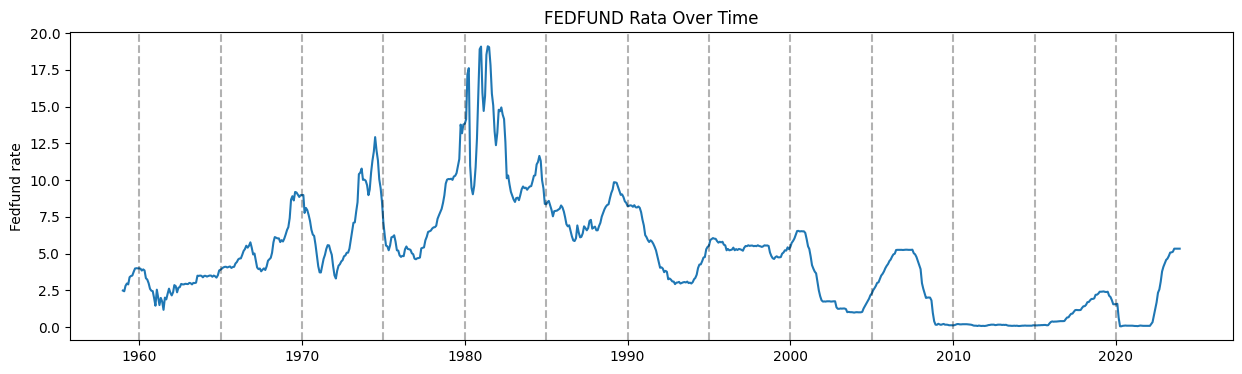

In [6]:
# Plot Time Series
plt.figure(figsize=(15,4))
plt.plot(fedfund)
plt.title("FEDFUND Rata Over Time")
plt.ylabel("Fedfund rate")
for year in range (fedfund.index[0].year+1,fedfund.index[-1].year +1, 5):
    plt.axvline(pd.to_datetime(str(year) +'-01-01'), color = 'k', linestyle = '--', alpha = 0.3)

## ACF and PACF graphs:

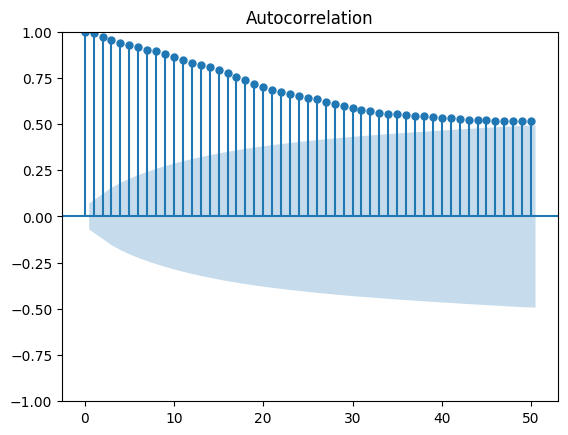

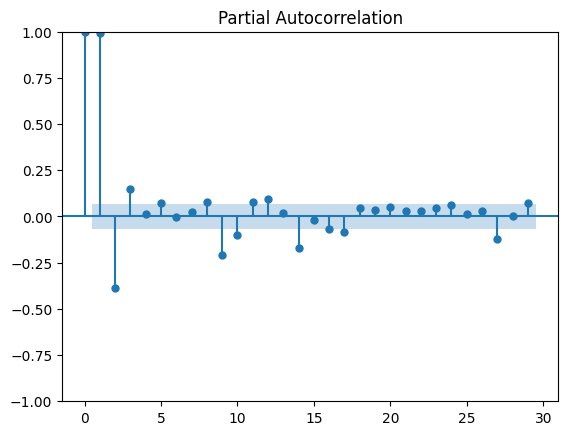

In [7]:
acf_plot = plot_acf(fedfund, lags=50)
pacf_plot = plot_pacf(fedfund)

In [8]:
# Define the Lag Order of the AR medel
p = 3

Observations: Strong spikes at 1,2,3. Maybe we should try fitting an AR(3), and Auto Regressive model with lags 1,2,3. [I have no idea what these spikes mean]

## Non-Rolling Forecast

In [9]:
# Get Training and Testing Set
train_end = datetime(2018,12,1)
test_end = datetime(2023,12,1)

train_data = fedfund[:train_end]
test_data = fedfund[train_end + timedelta(days=31):test_end]

In [10]:
# Create AR Model
model = ARIMA(train_data, order=(p,0,0))
#fit the model
model_fit = model.fit()
#Model Summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               FEDFUNDS   No. Observations:                  720
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -473.474
Date:                Fri, 01 Mar 2024   AIC                            956.949
Time:                        15:17:33   BIC                            979.845
Sample:                    01-01-1959   HQIC                           965.788
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6546      2.645      1.760      0.078      -0.530       9.839
ar.L1          1.4393      0.015     96.955      0.000       1.410       1.468
ar.L2         -0.6090      0.025    -24.076      0.0

In [11]:
#Prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

#Prediction residuals
predictions = model_fit.predict(start=pred_start_date, end = pred_end_date)
residuals = test_data - predictions

[]

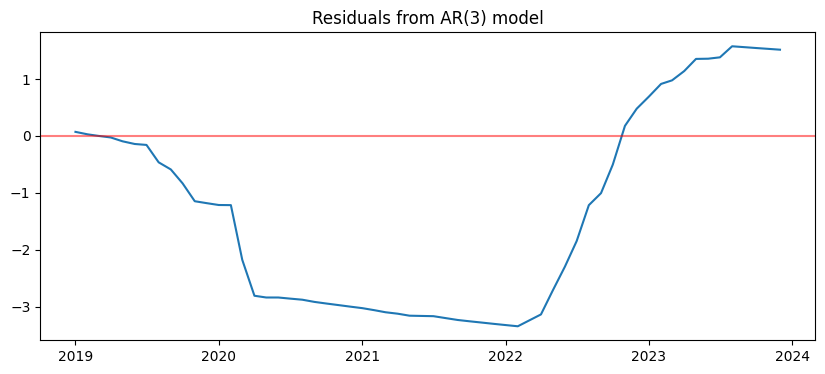

In [12]:
#Plot Residuals 
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title("Residuals from AR(3) model")
plt.axhline(0,color='r',alpha=0.5)
plt.plot()

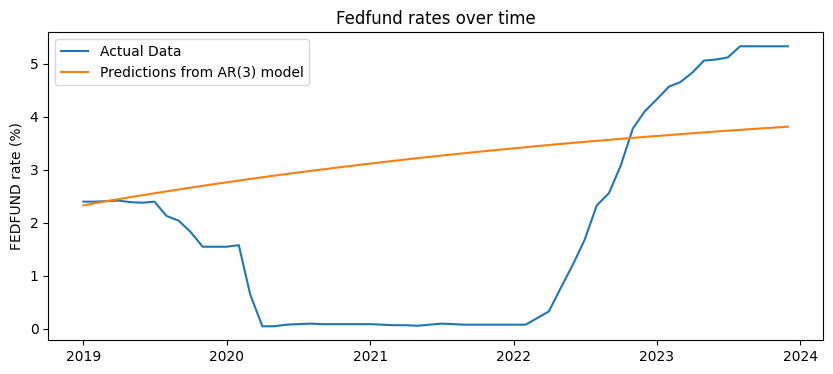

In [13]:
#Plot Predictions vs Actual 
plt.figure(figsize=(10,4))
plt.plot(test_data)
plt.plot(predictions)
plt.legend(("Actual Data", "Predictions from AR(3) model"))
plt.title("Fedfund rates over time")
plt.ylabel("FEDFUND rate (%)")
plt.show()

In [14]:
# Performance Metrics
mean_abs_percent_error = round(np.mean(abs(residuals/test_data)),4)
print("MAPE:", mean_abs_percent_error)
root_mean_squared_error = np.sqrt(np.mean(residuals**2))
print("RMSE:", root_mean_squared_error)

MAPE: 15.8673
RMSE: 2.202710354445373


## Roling Forecast Framework [1,3,6 Month Horizons]

The idea here is to create a model that take in all the data and predicts the next month.  For each date k in the test period. Train on dates 0 to k-1, and predict k.

I will run this algorithm using 1-month, 3-month and 6-month horizon


In [15]:
#Create Model
predictions_rolling_1m = pd.Series()
predictions_rolling_3m = pd.Series()
predictions_rolling_6m = pd.Series()
for end_date in test_data.index:
    #1month
    train_data_1m = fedfund[:end_date - pd.DateOffset(months=1)]
    model1 = ARIMA(train_data_1m, order=(p,0,0))
    model_fit1 = model1.fit()
    pred1 = model_fit1.predict(end_date)
    predictions_rolling_1m.loc[end_date] = pred1.loc[end_date]

    #3month
    train_data_3m = fedfund[:end_date - pd.DateOffset(months=3)]
    model3 = ARIMA(train_data_3m, order=(p,0,0))
    model_fit3 = model3.fit()
    pred3 = model_fit3.predict(end_date)
    predictions_rolling_3m.loc[end_date] = pred3.loc[end_date]

    #6month
    train_data_6m = fedfund[:end_date - pd.DateOffset(months=6)]
    model6 = ARIMA(train_data_6m, order=(p,0,0))
    model_fit6 = model6.fit()
    pred6 = model_fit6.predict(end_date)
    predictions_rolling_6m.loc[end_date] = pred6.loc[end_date]

In [16]:
#Calculate Residuals
residuals_rolling_1m = test_data - predictions_rolling_1m
residuals_rolling_3m = test_data - predictions_rolling_3m
residuals_rolling_6m = test_data - predictions_rolling_6m

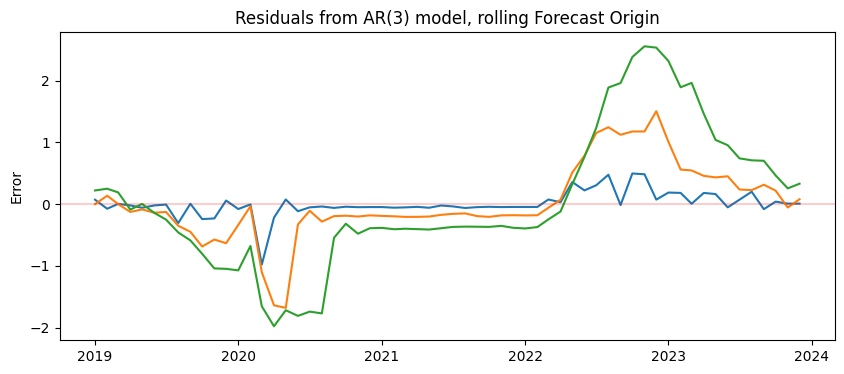

In [17]:
#Plot Residuals
plt.figure(figsize=(10,4))
plt.plot(residuals_rolling_1m)
plt.plot(residuals_rolling_3m)
plt.plot(residuals_rolling_6m)
plt.title("Residuals from AR(3) model, rolling Forecast Origin")
plt.ylabel("Error")
plt.axhline(0,color='r',alpha=0.2)
plt.show()

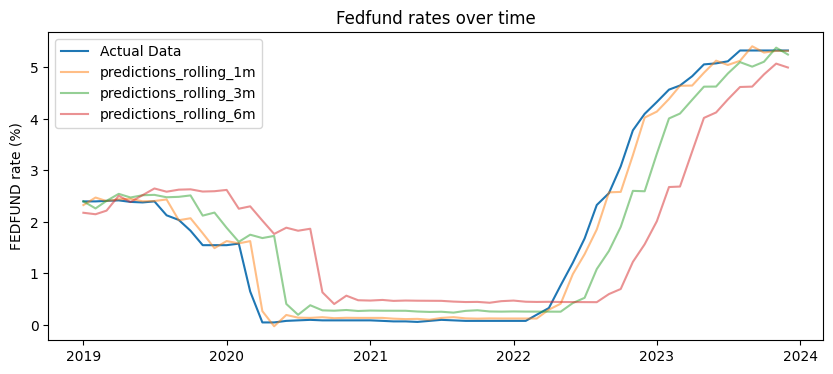

In [18]:
# Plot Predicted vs Actual
plt.figure(figsize=(10,4))
plt.plot(test_data)
plt.plot(predictions_rolling_1m, alpha=0.5)
plt.plot(predictions_rolling_3m, alpha=0.5)
plt.plot(predictions_rolling_6m, alpha=0.5)
plt.legend(("Actual Data", "predictions_rolling_1m","predictions_rolling_3m", "predictions_rolling_6m"))
plt.title("Fedfund rates over time")
plt.ylabel("FEDFUND rate (%)")
plt.show()

In [19]:
# Function to calculate MAPE and RMSE
def calculate_performance_metrics(residuals, actual):
    mean_abs_percent_error = round(np.mean(abs(residuals / actual)), 4)
    root_mean_squared_error = np.sqrt(np.mean(residuals**2))
    return mean_abs_percent_error, root_mean_squared_error

In [20]:
# 1-month horizon
mape_1m, rmse_1m = calculate_performance_metrics(residuals_rolling_1m, test_data)
print("1-Month Horizon - MAPE:", mape_1m, "%, RMSE:", rmse_1m)

# 3-month horizon
mape_3m, rmse_3m = calculate_performance_metrics(residuals_rolling_3m, test_data)
print("3-Month Horizon - MAPE:", mape_3m, "%, RMSE:", rmse_3m)

# 6-month horizon
mape_6m, rmse_6m = calculate_performance_metrics(residuals_rolling_6m, test_data)
print("6-Month Horizon - MAPE:", mape_6m, "%, RMSE:", rmse_6m)

1-Month Horizon - MAPE: 0.3862 %, RMSE: 0.20306986857646253
3-Month Horizon - MAPE: 2.0933 %, RMSE: 0.6027916787321977
6-Month Horizon - MAPE: 3.9532 %, RMSE: 1.1123975454691706
